In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shap.datasets import boston
from sklearn.linear_model import Ridge
from ensemble import utils, Ensemble

In [2]:
# Load data
X, Y = boston()
X = X.values
print(f'X.shape = {X.shape}, Y.shape = {Y.shape}')

# Split into training, val, test
val_portion = 0.2
test_portion = 0.2

# Shuffle inds
np.random.seed(0)
inds = np.arange(len(X))
np.random.shuffle(inds)
num_val = int(len(X) * val_portion)
num_test = int(len(X) * test_portion)

# Apply split
X_val, Y_val = X[:num_val], Y[:num_val]
X_test, Y_test = X[num_val:num_val+num_test], Y[num_val:num_val+num_test]
X_train, Y_train = X[num_val+num_test:], Y[num_val+num_test:]
del X, Y
print(f'train examples = {len(X_train)}, val examples = {len(X_val)}, test examples = {len(X_test)}')

X.shape = (506, 13), Y.shape = (506,)
train examples = 304, val examples = 101, test examples = 101


In [3]:
# Train models with random feature subsets
np.random.seed(0)
num_features = 5
num_models = 10
models = []
for _ in range(num_models):
    # Generate feature mask
    inds = np.random.choice(X_train.shape[1], num_features, replace=False)
    mask = np.zeros(X_train.shape[1])
    mask[inds] = 1
    
    # Train model
    model = Ridge(alpha=0.1)
    model.fit(X_train * mask, Y_train)
    models.append(model)

In [4]:
# Calculate performance metrics for each model
for model in models:
    # Training performance
    preds = model.predict(X_train)
    train_mse = utils.mean_squared_error(preds, Y_train)
    train_mae = utils.mean_absolute_error(preds, Y_train)

    # Validation performance
    preds = model.predict(X_val)
    val_mse = utils.mean_squared_error(preds, Y_val)
    val_mae = utils.mean_absolute_error(preds, Y_val)
    print(f'Train MSE = {train_mse:.2f}, train MAE = {train_mae:.2f}, val MSE = {val_mse:.2f}, val MAE = {val_mae:.2f}')

Train MSE = 55.81, train MAE = 5.25, val MSE = 35.13, val MAE = 4.64
Train MSE = 43.33, train MAE = 4.49, val MSE = 13.49, val MAE = 3.01
Train MSE = 54.35, train MAE = 5.26, val MSE = 23.84, val MAE = 3.71
Train MSE = 44.18, train MAE = 4.48, val MSE = 13.97, val MAE = 2.91
Train MSE = 46.61, train MAE = 4.54, val MSE = 10.85, val MAE = 2.69
Train MSE = 35.67, train MAE = 4.33, val MSE = 10.87, val MAE = 2.80
Train MSE = 34.64, train MAE = 4.26, val MSE = 23.73, val MAE = 3.82
Train MSE = 54.58, train MAE = 5.20, val MSE = 35.56, val MAE = 4.66
Train MSE = 33.65, train MAE = 4.09, val MSE = 17.39, val MAE = 3.25
Train MSE = 58.46, train MAE = 5.43, val MSE = 36.31, val MAE = 4.61


In [5]:
# Aggregate validation and test predictions
val_preds = {f'Ridge ({i})': model.predict(X_val) for i, model in enumerate(models)}
test_preds = {f'Ridge ({i})': model.predict(X_test) for i, model in enumerate(models)}

# Evaluate models in isolation
val_mse = {name: utils.mean_squared_error(preds, Y_val) for name, preds in val_preds.items()}
val_mae = {name: utils.mean_absolute_error(preds, Y_val) for name, preds in val_preds.items()}
test_mse = {name: utils.mean_squared_error(preds, Y_test) for name, preds in test_preds.items()}
test_mae = {name: utils.mean_absolute_error(preds, Y_test) for name, preds in test_preds.items()}

# Try SQP solver

In [6]:
from ensemble import utils
from ensemble.sqp_solvers import solve_regressor_mse
from ensemble.sqp_solvers import regressor_mse_helper

In [7]:
# Solve
simplex_weights = solve_regressor_mse(list(val_preds.values()), Y_val, 'simplex', verbose=True)
nonneg_weights = solve_regressor_mse(list(val_preds.values()), Y_val, 'nonnegative')
unconstrained_weights = solve_regressor_mse(list(val_preds.values()), Y_val, 'none')

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 10, constraints m = 11
          nnz(P) + nnz(A) = 75
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-08,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -5.5192e+02   9.98e-01   1.14e+08   1.00e-01   2.20e-04s
 200  -5.3095e+04   1.31e-06   1.75e-01   8.72e-03   5.78e-04s
 325  -5.3095e+04   5.95e-09   7.93e-04   8.72e-

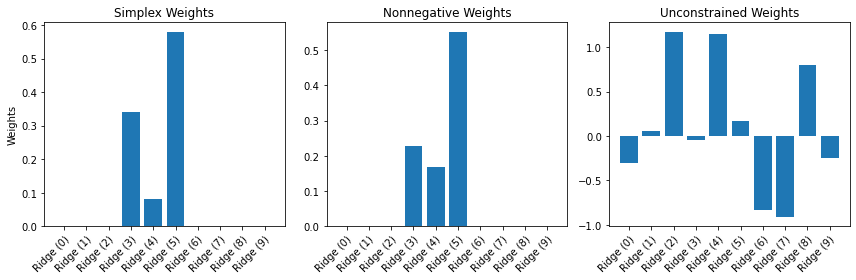

In [8]:
# Plot learned weights
fig, axarr = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(axarr[0])
plt.bar(range(len(models)), simplex_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Simplex Weights')
plt.ylabel('Weights')

plt.sca(axarr[1])
plt.bar(range(len(models)), nonneg_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Nonnegative Weights')

plt.sca(axarr[2])
plt.bar(range(len(models)), unconstrained_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Unconstrained Weights')

plt.tight_layout()
plt.show()

# Compare to CVXPY solver

- Problem: very different results when using simplex constraints
- Both solutions are feasible, but CVXPY solution gets better objective value -> problem must be with SQP implementation

In [9]:
# Get weights from CVXPY solver
ensemble = Ensemble('reg:mse', 'simplex')
ensemble_simplex_weights = ensemble.solver(list(val_preds.values()), Y_val, 'simplex', verbose=True)
ensemble_nonneg_weights = ensemble.solver(list(val_preds.values()), Y_val, 'nonnegative')
ensemble_unconstrained_weights = ensemble.solver(list(val_preds.values()), Y_val, 'none')

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jul 29 12:05:33 AM: Your problem has 10 variables, 2 constraints, and 0 parameters.
(CVXPY) Jul 29 12:05:33 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 29 12:05:33 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 29 12:05:33 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 29 12:05:33 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 29 12:05:33 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [10]:
# Consistency between CVXPY and SQP
print(f'CVXPY objective value (simplex): {regressor_mse_helper(list(val_preds.values()), Y_val, ensemble_simplex_weights)[0]}')
print(f'CVXPY objective value (nonneg): {regressor_mse_helper(list(val_preds.values()), Y_val, ensemble_nonneg_weights)[0]}')
print(f'CVXPY objective value (unconstrained): {regressor_mse_helper(list(val_preds.values()), Y_val, ensemble_unconstrained_weights)[0]}')
print(f'SQP objective value (simplex): {regressor_mse_helper(list(val_preds.values()), Y_val, simplex_weights)[0]}')
print(f'SQP objective value (nonneg): {regressor_mse_helper(list(val_preds.values()), Y_val, nonneg_weights)[0]}')
print(f'SQP objective value (unconstrained): {regressor_mse_helper(list(val_preds.values()), Y_val, unconstrained_weights)[0]}')

CVXPY objective value (simplex): 909.8056280648907
CVXPY objective value (nonneg): 754.1737750476739
CVXPY objective value (unconstrained): 456.581884640887
SQP objective value (simplex): 909.8056240357477
SQP objective value (nonneg): 754.1737705619641
SQP objective value (unconstrained): 456.58188464088676


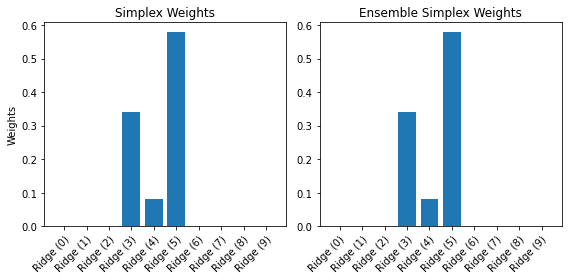

In [11]:
# Plot learned weights
fig, axarr = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axarr[0])
plt.bar(range(len(models)), simplex_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Simplex Weights')
plt.ylabel('Weights')

plt.sca(axarr[1])
plt.bar(range(len(models)), ensemble_simplex_weights)
plt.xticks(range(len(models)), val_preds.keys(), rotation=45,
           rotation_mode='anchor', ha='right')
plt.title('Ensemble Simplex Weights')

plt.tight_layout()
plt.show()